In [1]:
import numpy as np
from astropy.table import QTable
from astropy import units as u

import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LinearStretch, ZScaleInterval
from astropy.stats import sigma_clip
from astropy.io import fits
from scipy.stats import mode
import pandas as pd
import glob
from astropy.table import Table
from astropy.timeseries import TimeSeries, LombScargle
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
from photutils.centroids import centroid_1dg
from astropy.visualization import time_support
from astropy.time import Time

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
markarian_data = fits.getdata('/home/jovyan/work/480-paper/20250515/sci_reduced/Markarian421/reduced_science_0.fits') #load Markarian 421 data. attempts were made prior to the submission of this assignment to do science with the data we acquired, but it was ultimately not possible due to reading erros and not having enough data.

In [3]:
markarian_data #display data array

array([[24.730593 , 11.046084 , 27.21402  , ..., 22.350233 , 23.34889  ,
        -3.3241773],
       [25.91761  , 49.28213  , 34.523098 , ..., 42.34248  , 62.949165 ,
        24.881746 ],
       [26.806005 ,  8.670412 , 36.82894  , ..., 24.046753 , 10.710049 ,
        60.401836 ],
       ...,
       [10.551008 , 47.18439  , 33.459118 , ..., 14.71355  , 29.862911 ,
         5.6441097],
       [ 9.002636 , 21.949533 , 40.2774   , ..., 25.810423 ,  9.323262 ,
        45.404446 ],
       [41.274014 , 26.064188 , 27.757038 , ...,  4.0132213, 22.096664 ,
        -5.3460374]], shape=(1024, 1024), dtype='>f4')

In [4]:
fits.info('/home/jovyan/work/480-paper/20250515/sci_reduced/Markarian421/reduced_science_0.fits') #get header info

Filename: /home/jovyan/work/480-paper/20250515/sci_reduced/Markarian421/reduced_science_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     103   (1024, 1024)   float32   
  1  COSMICRAY_MASK    1 ImageHDU         8   (1024, 1024)   uint8   


In [5]:
tcorbor_data = fits.getdata('/home/jovyan/work/480-paper/20250515/sci_reduced/TCrB/reduced_science_0.fits') ##load T Cor Bor data. attempts were made prior to the submission of this assignment to do science with the data we acquired, but it was ultimately not possible due to reading erros and not having enough data.

In [6]:
tcorbor_data #display data array

array([[10.304413 , 16.223936 , 18.840475 , ..., 10.341152 , 23.34889  ,
        26.593418 ],
       [34.775524 , 51.293644 , 47.46926  , ..., 30.339886 , 49.03409  ,
        70.66416  ],
       [ 5.95689  , 23.676897 , 31.852058 , ...,  2.003896 , 29.787321 ,
        17.353016 ],
       ...,
       [43.225098 , 30.282518 , 27.25021  , ..., 26.75191  , 33.84463  ,
        16.600323 ],
       [ 5.886339 , 19.859102 , 32.08539  , ..., -4.963543 ,  0.3329736,
        21.366796 ],
       [16.71427  ,  2.0851352, 41.121536 , ..., 25.082634 , 30.131815 ,
        25.727804 ]], shape=(1024, 1024), dtype='>f4')

In [7]:
fits.info('/home/jovyan/work/480-paper/20250515/sci_reduced/TCrB/reduced_science_0.fits') #get header info

Filename: /home/jovyan/work/480-paper/20250515/sci_reduced/TCrB/reduced_science_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     103   (1024, 1024)   float32   
  1  COSMICRAY_MASK    1 ImageHDU         8   (1024, 1024)   uint8   


In [8]:
# get a list of FITS files in both days' directories
vesta_files_day_1 = glob.glob('/home/jovyan/work/480-paper/20250515/ASTRMET/NEW-VESTA-IMAGES-ASTMET/*.fits')
vesta_files_day_2 = glob.glob('/home/jovyan/work/480-paper/20250602/ASTRMET/*.fits')
vesta_files = vesta_files_day_1 + vesta_files_day_2
# Read all files into a list
hdul_list = [fits.open(file) for file in vesta_files]

#print headers of all files to check ra and dec header titles
for hdul in hdul_list:
    print(hdul[0].header)

#closing the files
for hdul in hdul_list:
    hdul.close()

SIMPLE  =                    T                                                  BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     NAXIS   =                    2 /number of axes                                  NAXIS1  =                 1024 /fastest changing axis                           NAXIS2  =                 1024 /next to fastest changing axis                   BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           DATE-OBS= '2025-05-16T04:17:56.399' / [ISO 8601] UTC date/time of exposure startEXPTIME =   5.00000000000E+000 / [sec] Duration of exposure                     EXPOSURE=   5.00000000000E+000 / [sec] Duration of exposure                     SET-TEMP=  -25.000000000000000 /CCD temperature setpoint in C                   CCD-TEMP=  -25.114567500000003 /CCD temperature at start of exposure in C       XPIXSZ  =   13.000000000000000 /Pixel Wi

In [9]:
rows = [] #create a blank array for data to be appended

In [10]:
for file in vesta_files:
    with fits.open(file) as hdul:
        header = hdul[0].header
        vesta_image_data = hdul[0].data
        # compute basic stats if not NaN of pixel flux
        if vesta_image_data is not None:
            mean_val = np.nanmean(vesta_image_data)
            std_val = np.nanstd(vesta_image_data)
            max_val = np.nanmax(vesta_image_data)
            min_val = np.nanmin(vesta_image_data)
        else:
            mean_val = std_val = max_val = min_val = None

        rows.append({
            'filename': file,
            'object': header.get('OBJECT'),
            'date_obs': header.get('DATE-OBS'),
            'ra': header.get('OBJCTRA'),
            'dec': header.get('OBJCTDEC'),
            'filter': header.get('FILTER'),
            'mean': mean_val,
            'std': std_val,
            'max': max_val,
            'min': min_val
        })

# create a dataframe
table = pd.DataFrame(rows)

In [11]:
time_ordered_data = table.sort_values('date_obs') #sort the data by the chronological order that the images were taken in

In [12]:
time_ordered_data #display table

,filename,object,date_obs,ra,dec,filter,mean,std,max,min
7,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:06:33.500,14 38 25.49,-03 51 52.3,g,1363.851753,540.796610,65535,1270
0,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:17:56.399,14 38 24.71,-03 51 52.1,g,1362.614141,530.299143,65535,1265
16,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:18:09.529,14 38 24.71,-03 51 52.1,g,1355.203801,539.989522,65535,1268
8,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:18:22.440,14 38 24.71,-03 51 52.1,g,1353.630376,540.313125,65535,1267
15,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:18:35.939,14 38 24.71,-03 51 52.1,g,1352.707134,531.905064,65535,1259
4,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:18:49.759,14 38 24.71,-03 51 52.1,g,1352.457916,530.032258,65535,1267
6,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:19:02.759,14 38 24.71,-03 51 52.1,g,1352.244569,528.035359,65535,1268
13,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:19:17.160,14 38 24.71,-03 51 52.1,g,1352.003057,536.469085,65535,1264
9,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:19:30.230,14 38 24.71,-03 51 52.1,g,1352.548121,529.137603,65535,1267
17,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:19:42.939,14 38 24.71,-03 51 52.1,g,1352.162364,526.534776,65535,1268


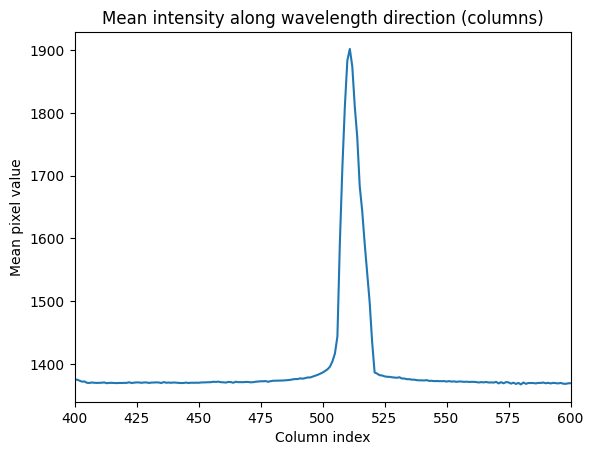

In [13]:
#to find an aperture of Vesta, we create a mean profile.
mean_profile = np.mean(vesta_image_data, axis=0)

plt.plot(mean_profile)
plt.xlim(400,600)
plt.title("Mean intensity along wavelength direction (columns)")
plt.xlabel("Column index")
plt.ylabel("Mean pixel value")
plt.show()
#using this plot and adjusting its x-limits, we can find our ideal aperture to be between 500 and 525, extend those to be conservative about getting Vesta centered in frame, and use that to focus on Vesta in our fits image produced below

In [14]:
time_ordered_data #Created a table of the data we have for Vesta, using selected headers from the fits files.

,filename,object,date_obs,ra,dec,filter,mean,std,max,min
7,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:06:33.500,14 38 25.49,-03 51 52.3,g,1363.851753,540.796610,65535,1270
0,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:17:56.399,14 38 24.71,-03 51 52.1,g,1362.614141,530.299143,65535,1265
16,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:18:09.529,14 38 24.71,-03 51 52.1,g,1355.203801,539.989522,65535,1268
8,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:18:22.440,14 38 24.71,-03 51 52.1,g,1353.630376,540.313125,65535,1267
15,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:18:35.939,14 38 24.71,-03 51 52.1,g,1352.707134,531.905064,65535,1259
4,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:18:49.759,14 38 24.71,-03 51 52.1,g,1352.457916,530.032258,65535,1267
6,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:19:02.759,14 38 24.71,-03 51 52.1,g,1352.244569,528.035359,65535,1268
13,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:19:17.160,14 38 24.71,-03 51 52.1,g,1352.003057,536.469085,65535,1264
9,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:19:30.230,14 38 24.71,-03 51 52.1,g,1352.548121,529.137603,65535,1267
17,/home/jovyan/work/480-paper/20250515/ASTRMET/N...,vesta,2025-05-16T04:19:42.939,14 38 24.71,-03 51 52.1,g,1352.162364,526.534776,65535,1268


In [15]:
#making a scatter plot light curve of Vesta using the mean flux within the aperture
plt.scatter(time_ordered_data['date_obs'],time_ordered_data['mean'])
plt.xticks(rotation=90)
plt.xlabel('Time (UTC)')
plt.ylabel('Flux')
plt.savefig('vestalightcurve.jpg')
plt.close()

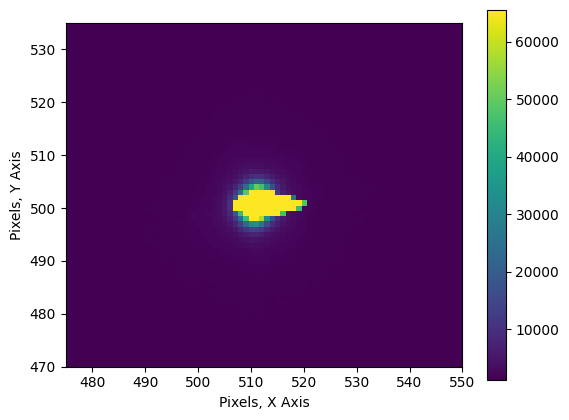

In [16]:
#loading a median data image of the Vesta fits files with a colormap
plt.imshow(vesta_image_data, cmap = 'viridis')
plt.xlim(475,550)
plt.ylim(470,535)
plt.xlabel('Pixels, X Axis')
plt.ylabel('Pixels, Y Axis')
plt.colorbar()